In [1]:
import random, time
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms

In [2]:
img_width = 28

In [3]:
batch_size = 32
layer_sizes = [784, 512]
learning_rate = 1e-4
n_epochs = 100

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

train_set = torchvision.datasets.FashionMNIST("./data", download=True,
                                              transform=transform)
indices = list(range(len(train_set)))
np.random.shuffle(indices)
train_after_split = SubsetRandomSampler(indices[:50000])
validation_after_split = SubsetRandomSampler(indices[50000:])

train_loader = torch.utils.data.DataLoader(train_set, sampler=train_after_split, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(train_set, sampler=validation_after_split, batch_size=batch_size)


test_set = torchvision.datasets.FashionMNIST("./data", download=True, 
             train=False, transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
             shuffle=False)

classes = ("T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot")

Our image batch shape is torch.Size([32, 1, 28, 28])


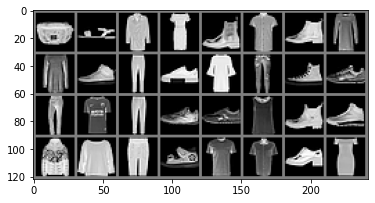

  Bag Sandal  Coat Dress


In [5]:
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
print("Our image batch shape is", images.size())
imshow(torchvision.utils.make_grid(images))

print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

In [6]:
def noise(x):
    """Apply noise to a single image
    Cuts out 1 or 2 quadrants randomly
    """
    x = np.array(x)  # Convert image to numpy array
    middle = int(img_width/2)  # Images are square
    for k in range(0,2):  # Noise is applied twice - if the offset matches, 
        x_offset = random.choice([0,middle]) # only a single quadrant is changed
        for i in range(x_offset, x_offset+middle):
            # All values in the quadrant are set to zero
            x[x_offset:x_offset+middle,x_offset:x_offset+middle] = \
                torch.zeros(x[x_offset:x_offset+middle,x_offset:x_offset+middle].shape)   
    x = torch.from_numpy(x)                     # Converted back to tensor
    return x
            
def apply_noise(imgs):
    """Apply noise to all images in a batch"""
    noisy_imgs = deepcopy(imgs)
            
    for i in range(0, len(imgs)):
        noisy_imgs[i][0] = noise(imgs[i][0])    # Add random noise to image values

    imgs = imgs.view(imgs.size(0), -1)          # Reshape tensors to 1D array
    noisy_imgs = noisy_imgs.view(noisy_imgs.size(0), -1)
    
    return imgs, noisy_imgs

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, layer_sizes):
        super(Autoencoder, self).__init__()
        self.layer_sizes = layer_sizes
        
        enc_layers = []
        for i in range(len(layer_sizes) - 1):
            enc_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            enc_layers.append(nn.ReLU(True))
        self.encoder = nn.Sequential(*enc_layers)
        
        dec_layers = []
        for i in reversed(range(1, len(layer_sizes))):
            dec_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i-1]))
            if i > 1: dec_layers.append(nn.ReLU(True))
        dec_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*dec_layers)
        
    def forward(self, input_x):
        encoded = self.encoder(input_x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
def PSNR(original, compressed): 
    mse = torch.mean((original - compressed) ** 2)
    return 20 * torch.log10(255.0 / torch.sqrt(mse))

In [16]:
def train(model, train_loader, val_loader, eval_acc, n_epochs=100, init_patience=5):
    train_losses = [] # To store loss for each epoch
    val_losses = []
    tick = time.perf_counter() #Timing training
    patience, epoch = init_patience, 0
    
    while epoch < n_epochs and patience > 0:
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        
        for train_imgs, _ in train_loader: # Iterate through training mini-batches
            train_imgs, train_noisy_imgs = apply_noise(train_imgs)   # Noise is added to all images in a batch
            model.zero_grad()                                    # Reset gradients 
            train_output = model(train_noisy_imgs)
            loss_func = mse_loss(train_output, train_imgs)           # Calculate MSE loss
            loss_func.backward()                                     # Backpropagation to update weights and bias
            optimizer.step()
            train_loss += loss_func.item()                           # Accumulated loss over all mini-batches
            train_acc += eval_acc(train_imgs, train_noisy_imgs)
            
        train_loss = train_loss/len(train_loader)                    # Calculate mean MSE loss for an image
        train_acc = train_acc/len(train_loader)
        train_losses.append(train_loss)
            
        model.eval()                                           # Enter evaluation mode
        with torch.no_grad():                                        # Disable gradients computation
            for val_imgs, _ in val_loader:                # Iterate through validation mini-batches
                val_imgs, val_noisy_imgs = apply_noise(val_imgs)     # Noise is added to all images in a batch
                
                val_output = model(val_noisy_imgs)
                loss_func = mse_loss(val_output, val_imgs)           # Calculate MSE loss
                val_loss += loss_func.item()                         # Accumulated loss over all mini-batches
                val_acc += eval_acc(val_imgs, val_noisy_imgs)
        
            val_loss = val_loss/len(validation_loader)               # Calculate mean MSE loss for an image
            val_acc = val_acc/len(validation_loader)
            val_losses.append(val_loss)
        
        print("Epoch {:3.0f}: Train Loss {:2.4f} | Train Acc {:3.2f} | Val Loss {:2.4f} | Val Acc {:3.2f}"
             .format(epoch, train_loss, train_acc, val_loss, val_acc))
        
         # check if converged
        if np.abs(val_losses[epoch] - val_losses[epoch - 1]) < 0.0001: patience -= 1
        else: patience = init_patience
        epoch += 1
    
    print(time.perf_counter() - tick)
    
    return train_losses, val_losses

In [17]:
m = Autoencoder(layer_sizes)
mse_loss = nn.MSELoss()
optimizer = optim.Adam(m.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses = train(m, train_loader, validation_loader, PSNR, n_epochs=10)

Epoch   0: Train Loss 0.6370 | Train Acc 53.98 | Val Loss 0.6070 | Val Acc 53.96
Epoch   1: Train Loss 0.6028 | Train Acc 53.97 | Val Loss 0.5996 | Val Acc 53.99
Epoch   2: Train Loss 0.5974 | Train Acc 53.98 | Val Loss 0.5957 | Val Acc 53.95


In [ ]:
# Plot the MSE loss for all epochs
def loss_plot(loss_training, label):
    plt.axis([0, n_epochs, min(loss_training), max(loss_training)])
    plt.plot(loss_training, label=label)
    plt.legend(loc='upper right')

In [ ]:
loss_plot(train_loss, "Training set MSE loss")
loss_plot(val_loss, "Validation set MSE loss")

In [ ]:
def test():
    test_iter = iter(test_loader)
    test_imgs, _ = test_iter.next()
    test_imgs, test_noisy_imgs = apply_noise(test_imgs)

    output = m(test_noisy_imgs)
    test_noisy_imgs = test_noisy_imgs.view(batch_size, 1, 28, 28)
    test_noisy_imgs = test_noisy_imgs.detach().numpy()
    test_imgs = test_imgs.view(batch_size, 1, 28, 28)
    test_imgs = test_imgs.detach().numpy()
    output = output.view(batch_size, 1, 28, 28)
    output = output.detach().numpy()

    zipped_list = []
    columns = 4
    for i in range(0,batch_size-columns+1,columns):
        zipped_list.append(test_imgs[i:i+columns])
        zipped_list.append(test_noisy_imgs[i:i+columns])
        zipped_list.append(output[i:i+columns])
    fig, axes = plt.subplots(nrows=int(3*batch_size/columns), ncols=columns, sharex=True, sharey=True, figsize=(10,40))
    for test_noisy_imgs, row in zip(zipped_list, axes):
        for img, ax in zip(test_noisy_imgs, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
test()